
# **Extract news category dataset and build a dummy classifier**
# Dataset:
  1000 subset of news from [News category dataset](https://rishabhmisra.github.io/publications) that contains news headlines with around 42 categories. For this training process, only four categories are used for training for a dummy classifier.
# Steps:
1.   Import needed libraries
2.   Text preprocessing (tokenization, stop word removal, punctuation removal, and lemmatization
3.   Using pandas to transform the datasets
4.   Build a dummy classifier using scikit-learn



In [ ]:
# Importing libraries
import pandas as pd
import json
from pandas import DataFrame as df
from pandas import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import spacy
from sklearn.datasets import fetch_20newsgroups
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import pickle
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
cd /root/nltk_data/corpora

/root/nltk_data/corpora


In [ ]:
!ls

dummy_classification_model.pkl	stopwords  stopwords.zip  wordnet  wordnet.zip


In [ ]:
!unzip wordnet.zip

Archive:  wordnet.zip
replace wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: wordnet/lexnames        
  inflating: wordnet/data.verb       
  inflating: wordnet/index.adv       
  inflating: wordnet/adv.exc         
  inflating: wordnet/index.verb      
  inflating: wordnet/cntlist.rev     
  inflating: wordnet/data.adj        
  inflating: wordnet/index.adj       
  inflating: wordnet/LICENSE         
  inflating: wordnet/citation.bib    
  inflating: wordnet/noun.exc        
  inflating: wordnet/verb.exc        
  inflating: wordnet/README          
  inflating: wordnet/index.sense     
  inflating: wordnet/data.noun       
  inflating: wordnet/data.adv        
  inflating: wordnet/index.noun      
  inflating: wordnet/adj.exc         


In [ ]:
data ={}
def read_json_file(file):
    with open(file, "r") as r:
        response = r.read()
        response = response.replace('\n', '')
        response = response.replace('}{', '},{')
        response = "[" + response + "]"
        return json.loads(response)

response = read_json_file("/content/newstext_2000.json")
data["News"] = response
df2 = json_normalize(data['News'])

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   link               999 non-null    object
 1   headline           999 non-null    object
 2   category           999 non-null    object
 3   short_description  999 non-null    object
 4   authors            999 non-null    object
 5   date               999 non-null    object
dtypes: object(6)
memory usage: 47.0+ KB


In [ ]:
print("Number of categories = ",df2['category'].nunique())

Number of categories =  26


In [ ]:
df2['category'].value_counts()

POLITICS          598
ENTERTAINMENT     356
U.S. NEWS         320
WORLD NEWS        255
SPORTS             83
CRIME              54
ENVIRONMENT        43
WELLNESS           37
FOOD & DRINK       36
STYLE & BEAUTY     28
COMEDY             26
WEIRD NEWS         24
CULTURE & ARTS     23
PARENTING          20
BUSINESS           20
HOME & LIVING      15
WOMEN              12
MEDIA              10
SCIENCE            10
TECH               10
BLACK VOICES        6
EDUCATION           5
TRAVEL              4
QUEER VOICES        2
MONEY               1
RELIGION            1
Name: category, dtype: int64

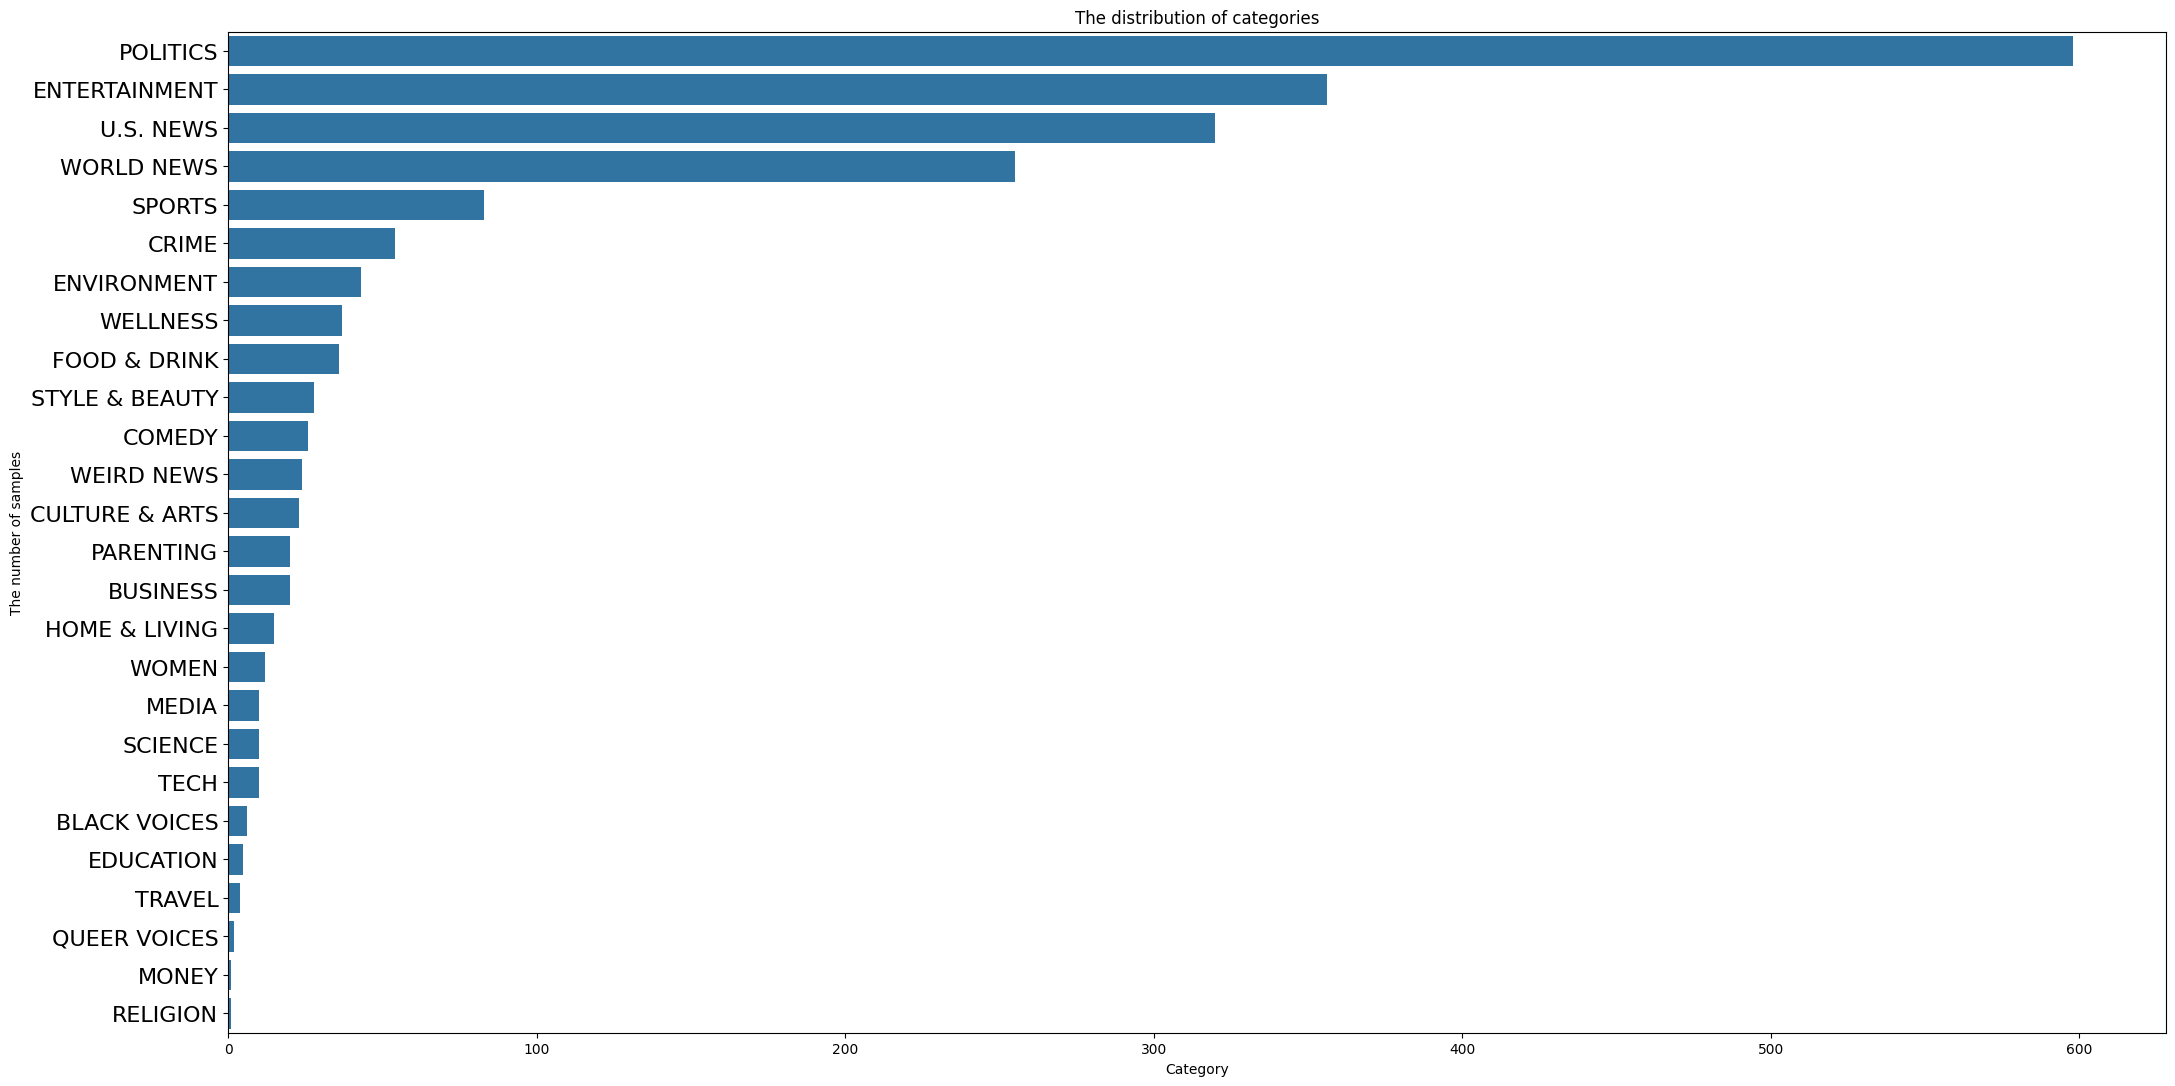

In [ ]:
plt.figure(figsize=(25,13))
sns.barplot(y=df2['category'].value_counts().index,x=df2['category'].value_counts().values)
plt.title("The distribution of categories")
plt.xlabel("Category")
plt.ylabel("The number of samples")

plt.yticks(rotation=0,fontsize = 16)
plt.show()

In [ ]:
#Concatenate headline and short_description into a full_article column
df2['full_article'] = df2['headline'] + " " + df2['short_description']

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower() #convert to lowercase letters
    tokens = nltk.word_tokenize(text) #word tokenization
    tokens = [token for token in tokens if token.isalpha()] #Remove puncutations and numbers
    tokens = [token for token in tokens if token not in stop_words] #Remove Stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens] #Lemmitization

    return tokens

In [ ]:
df2.loc[:, ('full_article_tokens')] = df2.loc[:,('full_article')].apply(lambda x: preprocess(x))
print(df2)

                                                   link  \
0     https://www.huffpost.com/entry/covid-boosters-...   
1     https://www.huffpost.com/entry/american-airlin...   
2     https://www.huffpost.com/entry/funniest-tweets...   
3     https://www.huffpost.com/entry/funniest-parent...   
4     https://www.huffpost.com/entry/amy-cooper-lose...   
...                                                 ...   
1994  https://www.huffpost.com/entry/pizza-roll-poop...   
1995  https://www.huffpost.com/entry/clarence-thomas...   
1996  https://www.huffpost.com/entry/get-dinner-on-t...   
1997  https://www.huffpost.com/entry/chrissy-teigen-...   
1998  https://www.huffpost.com/entry/bachelorette-ba...   

                                               headline       category  \
0     Over 4 Million Americans Roll Up Sleeves For O...      U.S. NEWS   
1     American Airlines Flyer Charged, Banned For Li...      U.S. NEWS   
2     23 Of The Funniest Tweets About Cats And Dogs ...         COMED

In [ ]:
df2['news_len'] = df2['full_article'].apply(lambda x: len(x))

In [ ]:
df2.groupby('category')['news_len'].mean().reset_index().sort_values(by='news_len',ascending=False)

,category,news_len
4,CULTURE & ARTS,217.608696
14,QUEER VOICES,199.000000
19,TECH,198.100000
5,EDUCATION,198.000000
13,POLITICS,197.132107
3,CRIME,196.370370
25,WORLD NEWS,193.215686
21,U.S. NEWS,193.190625
2,COMEDY,184.423077
17,SPORTS,184.216867


In [ ]:
df2.reset_index(inplace = True, drop = True)
print(df2)

                                                   link  \
0     https://www.huffpost.com/entry/covid-boosters-...   
1     https://www.huffpost.com/entry/american-airlin...   
2     https://www.huffpost.com/entry/funniest-tweets...   
3     https://www.huffpost.com/entry/funniest-parent...   
4     https://www.huffpost.com/entry/amy-cooper-lose...   
...                                                 ...   
1994  https://www.huffpost.com/entry/pizza-roll-poop...   
1995  https://www.huffpost.com/entry/clarence-thomas...   
1996  https://www.huffpost.com/entry/get-dinner-on-t...   
1997  https://www.huffpost.com/entry/chrissy-teigen-...   
1998  https://www.huffpost.com/entry/bachelorette-ba...   

                                               headline       category  \
0     Over 4 Million Americans Roll Up Sleeves For O...      U.S. NEWS   
1     American Airlines Flyer Charged, Banned For Li...      U.S. NEWS   
2     23 Of The Funniest Tweets About Cats And Dogs ...         COMED

In [ ]:
count = 0
max_threshold = df2['news_len'].std() *3 + df2['news_len'].mean()
min_threshold = abs(df2['news_len'].mean() - df2['news_len'].std()*3)
for num in df2['news_len']:
    if num > max_threshold or num < min_threshold:
      count += 1
print("The total outliers are = ",count)

The total outliers are =  7


In [ ]:
filtered_data = df2[(df2['news_len'] < max_threshold) & (df2['news_len'] > min_threshold )]
filtered_data.shape

(1992, 9)

In [ ]:
filtered_data.loc[:, ('full_article_tokens')] = filtered_data.loc[:,('full_article')].apply(lambda x: preprocess(x))

<ipython-input-79-b5017341b98e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, ('full_article_tokens')] = filtered_data.loc[:,('full_article')].apply(lambda x: preprocess(x))


In [ ]:
df2.drop(['authors','date'], axis=1, inplace = True)
df2.head()

,link,headline,category,short_description,full_article,full_article_tokens,news_len
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,Over 4 Million Americans Roll Up Sleeves For O...,"[million, american, roll, sleeve, covid, boost...",231
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,"American Airlines Flyer Charged, Banned For Li...","[american, airline, flyer, charged, banned, li...",249
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",23 Of The Funniest Tweets About Cats And Dogs ...,"[funniest, tweet, cat, dog, week, dog, underst...",134
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",The Funniest Tweets From Parents This Week (Se...,"[funniest, tweet, parent, week, accidentally, ...",216
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Woman Who Called Cops On Black Bird-Watcher Lo...,"[woman, called, cop, black, loses, lawsuit, am...",234


In [ ]:
df2['category'].value_counts()

POLITICS          598
ENTERTAINMENT     356
U.S. NEWS         320
WORLD NEWS        255
SPORTS             83
CRIME              54
ENVIRONMENT        43
WELLNESS           37
FOOD & DRINK       36
STYLE & BEAUTY     28
COMEDY             26
WEIRD NEWS         24
CULTURE & ARTS     23
PARENTING          20
BUSINESS           20
HOME & LIVING      15
WOMEN              12
MEDIA              10
SCIENCE            10
TECH               10
BLACK VOICES        6
EDUCATION           5
TRAVEL              4
QUEER VOICES        2
MONEY               1
RELIGION            1
Name: category, dtype: int64

In [ ]:
balanced_data = pd.DataFrame()
for category in ('POLITICS', 'ENTERTAINMENT','U.S. NEWS','WORLD NEWS'):
  data_temp = df2[df2['category'] == category]
  data_temp = (resample(data_temp, replace=False, n_samples=250, random_state=42))
  balanced_data = pd.concat([balanced_data,data_temp])

In [ ]:
balanced_data['category'].value_counts()

POLITICS         250
ENTERTAINMENT    250
U.S. NEWS        250
WORLD NEWS       250
Name: category, dtype: int64

In [ ]:
X = balanced_data.loc[:,df2.columns != 'category']
X.head()

,link,headline,short_description,full_article,full_article_tokens,news_len
404,https://www.huffpost.com/entry/election-2024-t...,How A Crowded GOP Field Could Bolster A Trump ...,As Donald Trump considers another White House ...,How A Crowded GOP Field Could Bolster A Trump ...,"[crowded, gop, field, could, bolster, trump, c...",175
1051,https://www.huffpost.com/entry/ketanji-brown-j...,Top Law Enforcement Officials Back Judge Ketan...,Jackson has also been praised by defense attor...,Top Law Enforcement Officials Back Judge Ketan...,"[top, law, enforcement, official, back, judge,...",147
1903,https://www.huffpost.com/entry/cyber-ninjas-ar...,'Laughable' Cyber Ninjas' Arizona Recount Miss...,"The election auditors missed 16,000 votes in a...",'Laughable' Cyber Ninjas' Arizona Recount Miss...,"[cyber, ninja, arizona, recount, missed, vote,...",237
317,https://www.huffpost.com/entry/democrats-recon...,Democrats' Reconciliation Package The 'Biggest...,The deal Democrats struck late Thursday includ...,Democrats' Reconciliation Package The 'Biggest...,"[democrat, reconciliation, package, climate, a...",236
662,https://www.huffpost.com/entry/donald-trump-tw...,Donald Trump Is Back On Twitter,The former president's Truth Social messages a...,Donald Trump Is Back On Twitter The former pre...,"[donald, trump, back, twitter, former, preside...",157


In [ ]:
y = balanced_data['category']

In [ ]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X, y, random_state=1, test_size = 0.30, train_size = 0.7, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=1, test_size = 0.3, train_size = 0.7, stratify=y_train_plus_valid)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(489, 6)
(210, 6)
(300, 6)


In [ ]:
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(489,)
(210,)
(300,)


In [ ]:
vectorizer = CountVectorizer(max_features = 1000)

In [ ]:
X_train_vectorized = vectorizer.fit_transform(X_train_plus_valid['full_article_tokens'].apply(lambda x: ' '.join(x)))
X_test_vectorized = vectorizer.transform(X_test['full_article_tokens'].apply(lambda x: ' '.join(x)))

In [ ]:
def classify_text(clf, doc, labels=None):
  probas = clf.predict_proba([doc]).flatten()
  max_proba_idx = np.argmax(probas)

  if labels:
    most_proba_class = labels[max_proba_idx]
  else:
    most_proba_class = max_proba_idx

  return (most_proba_class, probas[max_proba_idx])

In [ ]:
# Train a dummy classifier which guesses the category randomly.
dummy_clf_1 = DummyClassifier(strategy="uniform")
dummy_clf_1.fit(X_train_vectorized, y_train_plus_valid)


DummyClassifier(strategy='uniform')

In [ ]:
# Train a dummy classifier which guesses most frequent category.
dummy_clf_2 = DummyClassifier(strategy="most_frequent")
dummy_clf_2.fit(X_train_vectorized, y_train_plus_valid)


DummyClassifier(strategy='most_frequent')

In [ ]:
s = "government imposed a curfew"
classify_text(dummy_clf_1, s, ["POLITICS","ENTERTAINMENT", "U.S. NEWS", "WORLD NEWS "] )

('POLITICS', 0.25)

In [ ]:
filename = 'dummy_classification_model.pkl'
pickle.dump(dummy_clf_1, open(filename, 'wb'), -1)